In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, ReLU, MaxPool2D, AvgPool2D, Input, LeakyReLU, concatenate, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from random import choice
from tensorflow.keras.models import Model
from keras.layers import add
%matplotlib inline
tf.random.set_seed(0)
import os

In [4]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
IMAGE_COUNT=5000
AUTOTUNE = tf.data.AUTOTUNE

# Leer imagenes

In [5]:
path_train = "train"
path_test = "test1"
batch_size = 15
class_names = ["dog", "cat"]

In [6]:
dogs = tf.data.Dataset.list_files('train/dog/*.jpg').take(IMAGE_COUNT)
cats = tf.data.Dataset.list_files('train/cat/*.jpg').take(IMAGE_COUNT)
list_ds = dogs.concatenate(cats).shuffle(IMAGE_COUNT*2)

In [7]:
for f in list_ds.take(5):
  print(f.numpy())

b'train/dog/dog.8757.jpg'
b'train/cat/cat.9621.jpg'
b'train/dog/dog.5025.jpg'
b'train/cat/cat.1142.jpg'
b'train/cat/cat.8157.jpg'


In [8]:
val_size = int(IMAGE_COUNT * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [9]:
# Se imprime la longitud de cada conjunto de datos
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

9000
1000


In [10]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
  return img

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [11]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  1


In [13]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
# train_datagen = ImageDataGenerator(validation_split=0.2)

In [ ]:
# train_generator = train_datagen.flow_from_directory(path_train, target_size=IMAGE_SIZE, shuffle=True, color_mode="rgb", class_mode="sparse", batch_size=batch_size, subset="training")

In [ ]:
# validation_generator = train_datagen.flow_from_directory(path_train, target_size=IMAGE_SIZE, shuffle=False, color_mode="rgb", class_mode="sparse", batch_size=batch_size, subset="validation")

In [ ]:
# def plot_random_image(path, list_of_images_paths):
#   #Seleccionar aleatoriamente una imagen
#   random_image_path = choice(list_of_images_paths)

#   #Cargar la imagen
#   image = Image.open(path + "/" + random_image_path).convert("RGBA")

#   #Mostrar la imagen
#   plt.imshow(image)
#   plt.axis("off")

In [ ]:
# plot_random_image(path_train, train_generator.filenames)

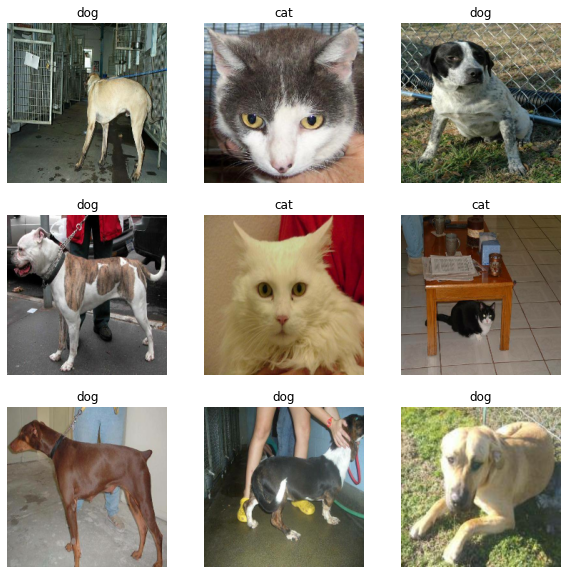

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# Crear modelo

In [15]:
def create_model():
    K.clear_session()
    in_layer = Input(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS))
    zero_p_1 = ZeroPadding2D(padding=(2, 2))(in_layer)
    conv_1 = Conv2D(96, (11, 11), strides=4, activation='relu', padding = "valid")(zero_p_1)
    mp_1 = MaxPool2D((2, 2))(conv_1)

    zero_p_2 = ZeroPadding2D(padding=(2, 2))(mp_1)
    conv_2 = Conv2D(256, (5, 5), activation='relu')(zero_p_2)
    mp_2 = MaxPool2D((2, 2))(conv_2)

    zero_p_3 = ZeroPadding2D(padding=(1, 1))(mp_2)
    conv_3 = Conv2D(384, (3, 3), activation='relu')(zero_p_3)
    
    zero_p_4 = ZeroPadding2D(padding=(1, 1))(conv_3)
    conv_4 = Conv2D(384, (3, 3), activation='relu')(zero_p_4)
    
    zero_p_5 = ZeroPadding2D(padding=(1, 1))(conv_4)
    conv_5 = Conv2D(256, (3, 3), activation='relu')(zero_p_5)

    flatten = Flatten()(conv_5)
    drop_1 = Dropout(0.5)(flatten)
    dense_1 = Dense(4096,activation='relu')(drop_1)
    drop_2 = Dropout(0.3)(dense_1)
    dense_2 = Dense(64,activation='relu')(drop_2)
    out_layer = Dense(2,activation='softmax')(dense_2)

    model = Model(inputs=in_layer, outputs=out_layer)
    return model

In [16]:
lr = 0.001
momentum = 0.9
model = create_model()
model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 228, 228, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 31, 31, 96)       0         
 ng2D)                                                           
                                                             

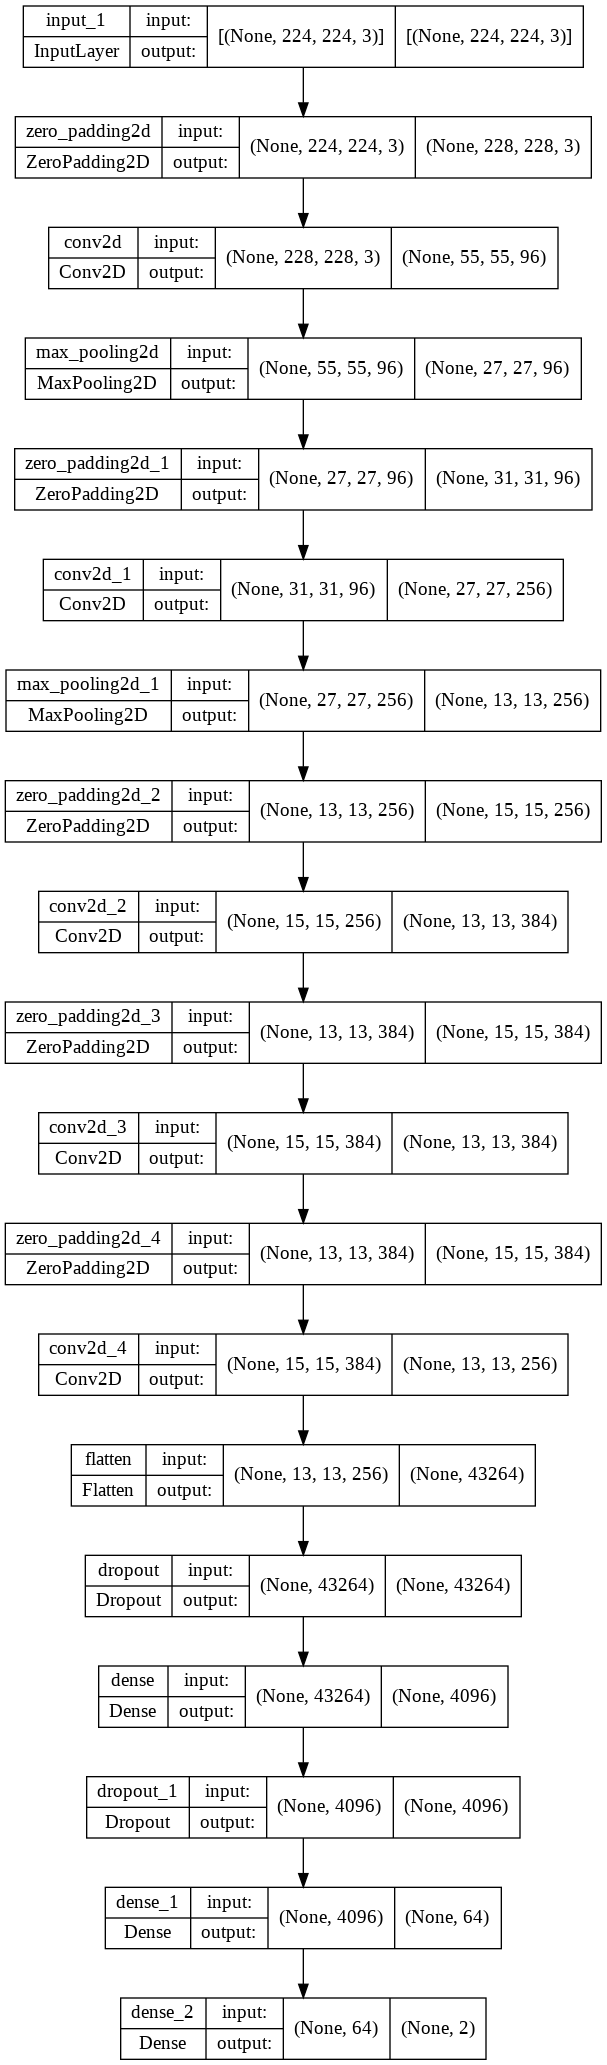

In [18]:
tf.keras.utils.plot_model(model,show_shapes=True)

# Entrenar modelo

In [19]:
def show_results(log):
  loss = log.history['loss']
  acc = log.history['accuracy']

  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
  
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes

  ax1.plot(loss, label='train')
  ax1.plot(val_loss, label='test')
  
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  
  ax2.plot(acc, label='train')
  ax2.plot(val_acc, label='test')
  
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  
  for ax in axes: ax.legend()

In [20]:
log = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
600/600 [==============================] - 52s 76ms/step - loss: 1.0041 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 2/10
600/600 [==============================] - 32s 54ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 3/10
600/600 [==============================] - 32s 54ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 4/10
600/600 [==============================] - 32s 54ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 5/10
600/600 [==============================] - 32s 54ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 6/10
600/600 [==============================] - 33s 54ms/step - loss: 0.6931 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 7/10
600/600 [==============================] - 33s 54ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy:

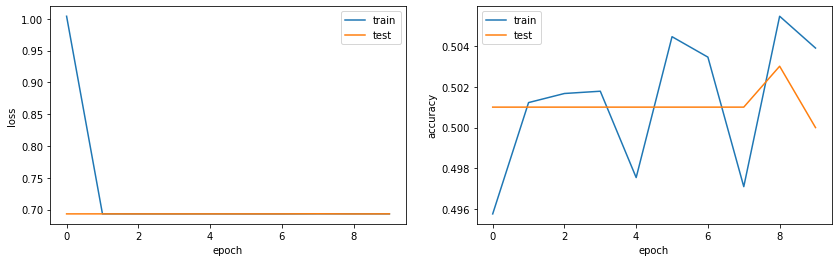

In [21]:
show_results(log)

# Probando modelo

In [ ]:
def get_class(path, random_image_path, final_model):
  #Cargar la imagen del path
  img = Image.open(path + "/" + random_image_path).convert("L")
  
  #Mostrar la imagen
  plt.imshow(img)
  plt.axis('off')
  
  #Cambiar el tamaño de la imagen
  img_resized = img.resize((img_size, img_size))

  #Cambiar a formato numpy
  x = np.asarray(img_resized, np.float32)
  x = x[None]
  
  #Obtener la predicción
  y = model.predict(x)
  
  #Decodificar la predicción
  pred = y[0]
  
  real = random_image_path.split("/", 1)[0]
  
  plt.title(f"Real value = {real} - Model prediction = {pred}")
  plt.show()

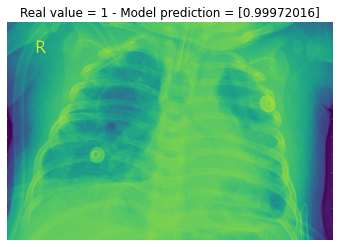

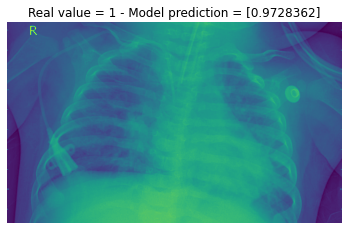

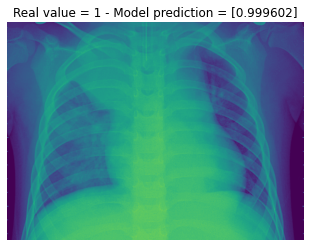

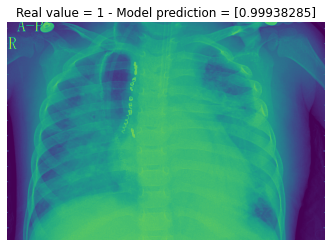

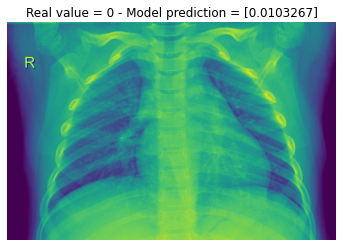

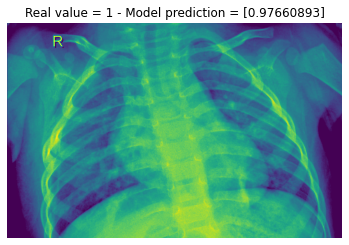

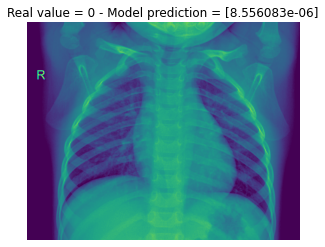

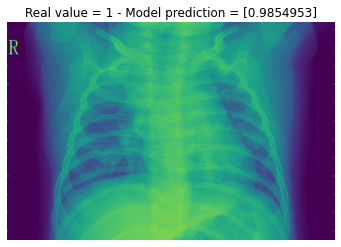

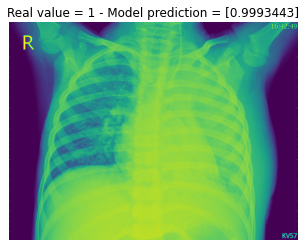

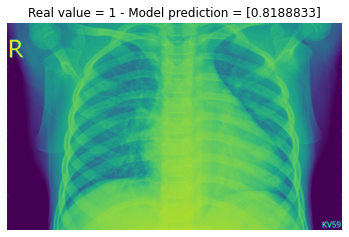

In [ ]:
number_of_images_to_test = 10

for _ in range(number_of_images_to_test):
  random_image_path = choice(validation_generator.filenames)
  
  get_class(path_train, random_image_path, model)

# Aplicando modelo

In [ ]:
def apply_model(path, filenames):
  scores = []
  for count, filename in enumerate(filenames):
    print(count)
    img = keras.preprocessing.image.load_img(
        path + "/" + filename, target_size=(img_size, img_size), color_mode='grayscale'
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0][0]
    scores.append(score)
  return scores

In [ ]:
df_test = pd.read_csv('test_x.csv')
df_test

,Id,File_names
0,0,1a8e3b37-63d9-5fbc-ac08-1575de9ca7b3.jpeg
1,1,c802f47b-126d-54da-8560-af9fc64594c0.jpeg
2,2,72cf7ea5-294a-5af3-8e75-4cddd685e9c7.jpeg
3,3,79080b42-3598-5418-930e-c6c29f59bf33.jpeg
4,4,57b2427f-dd56-5d1e-b5ad-84459c5a658a.jpeg
...,...,...
874,874,eb112bed-7fd8-5b95-b606-5702e99c2aeb.jpeg
875,875,91c955e8-69c0-5d3e-bf0b-f71f2d05d4c5.jpeg
876,876,7e58d895-e287-5eec-8dbb-b77b263256de.jpeg
877,877,a499be27-7868-5b75-a5fa-e8ef81529507.jpeg


In [ ]:
path_test = "images/test"
scores = apply_model(path_test, df_test['File_names'])
scores

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[0.9854708,
 0.9997346,
 5.3823158e-05,
 1.0,
 0.99973327,
 0.005841713,
 5.782051e-05,
 0.7066034,
 0.99999976,
 1.0,
 0.9999559,
 0.9963899,
 0.99999964,
 0.999944,
 1.0,
 0.99994516,
 0.99999917,
 0.983297,
 0.9999995,
 0.9998356,
 0.00056150847,
 0.9008391,
 0.002540792,
 0.9999583,
 0.9989976,
 0.99995446,
 0.9999869,
 1.0,
 0.0018679642,
 0.0036182266,
 0.05174873,
 0.9999579,
 0.4635769,
 0.9999999,
 0.9999858,
 0.9977719,
 2.0444575e-06,
 0.99986744,
 0.00052036275,
 1.0,
 0.9980147,
 0.9359283,
 0.99999964,
 0.9998568,
 0.9999865,
 0.079096794,
 0.99598545,
 0.99977285,
 0.0008153073,
 0.9999995,
 0.99961734,
 0.9999981,
 0.8090847,
 0.99999774,
 0.98425573,
 0.99999595,
 1.0,
 3.7300988e-06,
 0.9998995,
 1.6054454e-06,
 0.99999774,
 1.0,
 0.9499776,
 5.3772983e-05,
 0.0013198213,
 0.00021314976,
 0.7902055,
 0.99999344,
 0.99863786,
 0.6272944,
 0.9999994,
 0.9998685,
 0.205707,
 0.46250802,
 0.99999714,
 1.0,
 0.99989176,
 1.2760052e-05,
 1.200542e-06,
 0.99385875,
 0.000591

In [ ]:
df_test['Predicted'] = scores
df_test[['Id', 'Predicted']].to_csv('tensor_testers_submission (16).csv',index=False)